In [1]:
# !huggingface-cli login
#huggingface-cli login --token YOUR_TOKEN_GOES_HERE

# run from bash

In [2]:
import os
os.environ["TRANSFORMERS_CACHE"] = "D:/Students/henrysun/huggingface"
os.environ["HF_HOME"] = "D:/Students/henrysun/huggingface"
print(os.environ.get("HF_HOME"))

D:/Students/henrysun/huggingface


## Testing w/ dreambooth for batch generation


In [3]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# run this first

c:\Users\hs325\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\hs325\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\transformers\utils\hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


In [4]:
# pipe = DiffusionPipeline.from_pretrained("henrysun9074/dreambooth-out", torch_dtype=torch.bfloat16).to("cuda")
# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
# pipe.enable_attention_slicing()   

# prompt = "a drone image of a humpback whale"
# image = pipe(prompt).images[0]
# image

c:\Users\hs325\AppData\Local\anaconda3\envs\pytorch\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\Students\henrysun\huggingface\hub\models--stabilityai--stable-diffusion-xl-base-1.0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.80it/s]

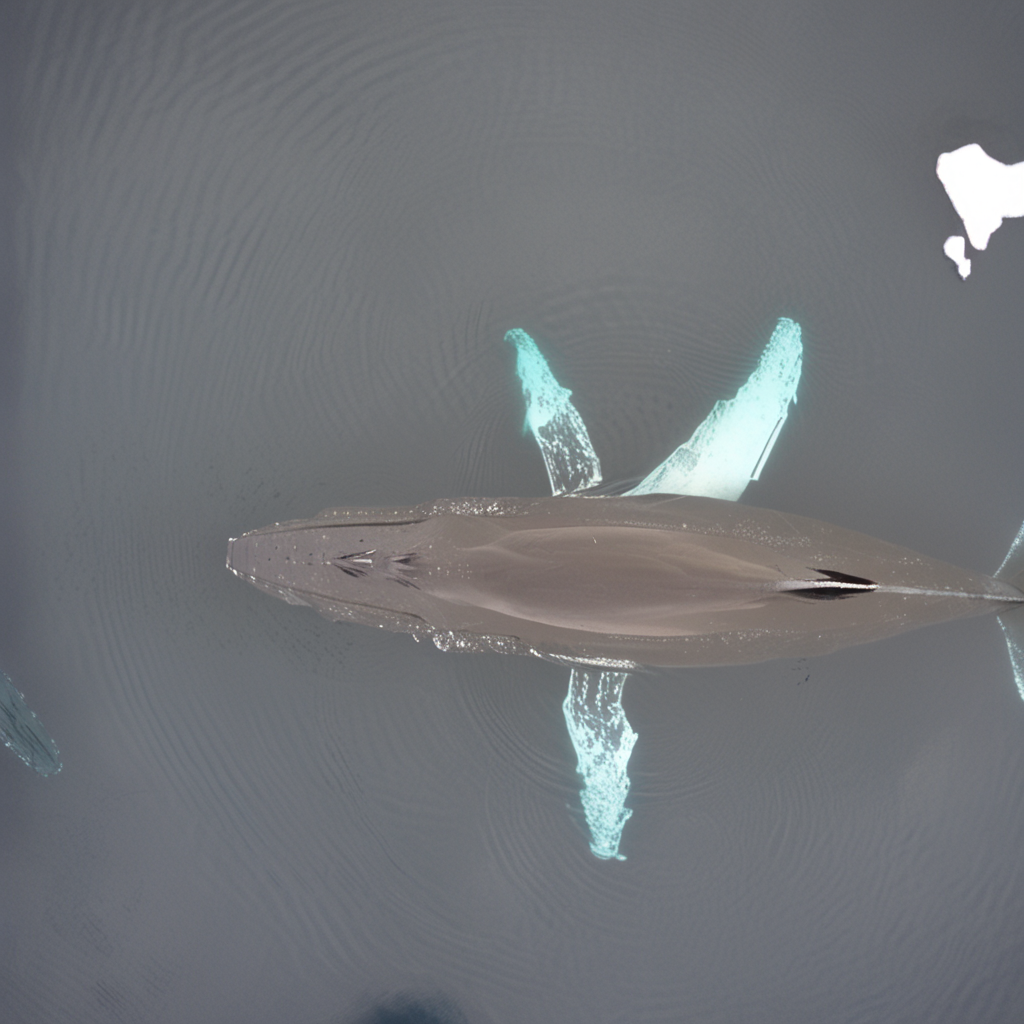

In [5]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Initialize pipeline
# pipe_id = "stable-diffusion-v1-5/stable-diffusion-v1-5" # need SDXL 1.0?
pipe_id = "stabilityai/stable-diffusion-xl-base-1.0"

pipe = DiffusionPipeline.from_pretrained(pipe_id, torch_dtype=torch.bfloat16).to("cuda")
pipe.load_lora_weights("henrysun9074/drone-humpback-whale-lora-1", weight_name="drone-humpback-whale-lora-1.safetensors", adapter_name="humpback")
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_attention_slicing()

prompt = "A drone photo of a humpback whale swimming in the ocean"
image = pipe(prompt).images[0]
image

In [ ]:
def get_inputs(batch_size, seed_offset):
    generator = [torch.Generator("cuda").manual_seed(seed_offset + i) for i in range(batch_size)]
    prompts = batch_size * [prompt]
    num_inference_steps = 20
    return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

# Generate images in multiple batches
def generate_images(pipe, total_images, batch_size):
    all_images = []
    seed_offset = 0  # For unique seeds across batches

    for _ in range(total_images // batch_size):
        inputs = get_inputs(batch_size, seed_offset)
        images = pipe(**inputs).images
        all_images.extend(images)

        # Free GPU memory
        torch.cuda.empty_cache()

        seed_offset += batch_size

    return all_images

total_images = 512
batch_size = 8
images = generate_images(pipe, total_images, batch_size)

def make_image_grid(images, rows, cols):
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np

    grid = Image.new("RGB", (cols * images[0].width, rows * images[0].height))
    for i, img in enumerate(images):
        grid.paste(img, box=(i % cols * img.width, i // cols * img.height))
    plt.imshow(np.asarray(grid))
    plt.axis("off")
    plt.show()

make_image_grid(images, 32, 16)


100%|██████████| 20/20 [01:48<00:00,  5.40s/it]


In [ ]:
import os
from PIL import Image
import zipfile
import shutil

# Create a folder to store images
output_folder = "D:\Projects\HappyHumpbacks\images\hhv1DBbatchgen"
os.makedirs(output_folder, exist_ok=True)

# Save images
for idx, img in enumerate(images):
    img_path = os.path.join(output_folder, f"image_{idx + 1}.png")
    img.save(img_path)

# Compress images into a zip file
zip_path = f"{output_folder}.zip"
with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(output_folder):
        for file in files:
            zipf.write(os.path.join(root, file), arcname=file)

print(f"Images saved and compressed into {zip_path}")

# Clean up: Uncomment to delete the generated image folder after compression
# shutil.rmtree(output_folder)